# Lecture Course on "Computational Quantum Dynamics"

__This project has been carried out by:__ Mathieu Kaltschmidt and Carl von Randow

# The Gross-Pitaevskii equation (GPE): Dynamics of solitons and vortices

The GPE is a mean field equation that has been incredibly successful in describing the dynamics of Bose Einstein condensates (BECs). The equation features a non-linear term and thus allows for stable soliton solutions in 1D and additional topological defects such as vortices in 2D. The goal of this project is to study these phenomena using the split-step Fourier method.

In [1]:
#Importing packages and some basic settings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from mpl_toolkits import mplot3d

#Fast Fourier transforms
from numpy.fft import fft, ifft, fftshift, fftfreq

#Some plot setings
import matplotlib as mpl
mpl.rcParams['legend.handlelength'] = 0.5
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    "font.sans-serif": ["Deja Vu Sans"], # use a specific sans-serif font
}
mpl.rcParams.update(pgf_with_rc_fonts)

Mymarkersize = 3.5
myfontsize = 3

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman'], 'size':myfontsize})
rc('text', usetex=True)
rc('legend', fontsize=3.0)

#Other useful packages
import sys
import h5py as h
import scipy.special as special
import scipy.ndimage as ndimage
from scipy.optimize import curve_fit, newton
from scipy.interpolate import interp1d
import scipy.optimize as optimization
import timeit

plt.style.use('seaborn-talk')

## 1) The evolution of dark solitons in a homogeneous 1D Bose gas

#### Numerical solution

In [2]:
#Some basic parameters of our setting
hbar = 1
n = 1
m = 10 
g = 1e-2 #non-linear GPE coupling

xi = 4 #1/np.sqrt(m*n*g)  # healing length, resolved with 4 grid points
rho = 1./(2*g*xi**2)    #homogeneous background density
print("Homogeneous background density:" , rho)

#Defining a spatial grid structure with periodic boundary conditions
L = 240
Ngrid = 512 #number of gridpoints

N = rho * Ngrid
print("Particle number: " , N)

dx = L/Ngrid
grid = np.linspace(-L/2,L/2-dx,Ngrid) / 2 #in units of the healing length

#Grid structure in in momentum-space
dk_x = (2*np.pi)/(len(grid)*dx)
k_x = dk_x*np.arange(-Ngrid/2,Ngrid/2)

Homogeneous background density: 3.125
Particle number:  1600.0


In [3]:
#defining the density distribution and the potential
def Density1D(z):
    return rho * np.ones(len(z))

def FreePotential1D(z):
    return np.zeros(len(z))

#density = Density1D(grid)
#V = FreePotential1D(grid)

In [4]:
#Implementing the Split-Step-Fourier-method for our problem
def SSFT(init, V, grid, kx):
    #Initialization
    ssft_x = np.zeros((2*tsteps + 2, Ngrid), dtype=np.complex128)
    ssft_k = np.zeros((2*tsteps + 1, Ngrid), dtype=np.complex128)
    
    (ssft_x[0], ssft_x[1]) = (init, np.exp(-1j*hbar*dt*(V(grid) + g*np.abs(init)**2)/2)*init)
    (ssft_k[0], ssft_k[1]) = (fftshift(fft(init)), fftshift(fft(ssft_x[1])))
    
    for t in np.arange(1,tsteps):
        ssft_k[2*t] = np.exp(-1j*hbar*dt*(kx**2)/(2*m))*ssft_k[2*t-1]
        ssft_x[2*t] = ifft(fftshift(ssft_k[2*t]))
        ssft_x[2*t+1] = np.exp(-1j*hbar*dt*(V(grid) + g*np.abs(ssft_x[2*t])**2))*ssft_x[2*t]
        ssft_k[2*t+1] = fftshift(fft(ssft_x[2*t+1]))
     
    #last step in momentum space and last half step in spatial coordinates
    ssft_k[2*tsteps] = np.exp(-1j*hbar*dt*(kx**2)/(2*m))*ssft_k[2*tsteps-1]
    ssft_x[2*tsteps] = ifft(fftshift(ssft_k[2*tsteps]))
    ssft_x[2*tsteps+1] = np.exp(-1j*hbar*dt*(V(grid) + g*np.abs(ssft_x[2*tsteps])**2)/2)*ssft_x[2*tsteps]
        
    (ssft_x, ssft_k) = (np.real(ssft_x), np.real(ssft_k))
    
    return ssft_x, ssft_k

In [5]:
#analytical solution from paper as comparison
"""
diese Sachen braucht man teilweise schon für InitSoliton, wusste jetzt nicht genau,
ob die jetzt einfach hier so stehen sollen oder wie es am besten wäre
außerdem hat m gefehlt, wusste jetzt nicht, ob es 1 sein soll oder 1e-25 oder so?
"""
#m = 1 # oder anderer wert??
nu = 0.3 #greyness (we want to study different greynes levels)
gamma = 1/np.sqrt(1-nu**2)
c_s = np.sqrt(rho*g/m)

#xi = 4
mu = 1 #maybe inverting the function for xi???

In [6]:
def InitSoliton(z, z0, nu ):
    return np.sqrt(rho) * (1j*nu + gamma**(-1) * np.tanh((z - z0)/(np.sqrt(2)*xi*gamma)))

#time steps
dt = 0.05
tsteps = 100
time = np.array([0, *dt*np.arange(0.5, tsteps, 1/2),tsteps*dt])

<IPython.core.display.Javascript object>


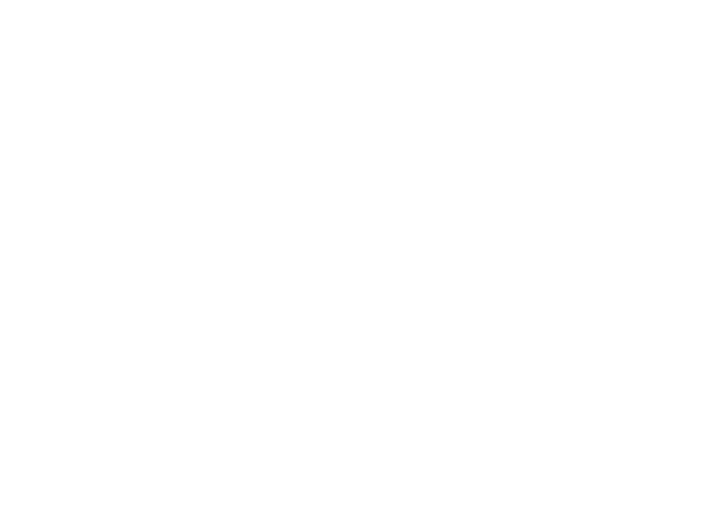

In [7]:
%matplotlib notebook
plt.rcParams["figure.figsize"][0] = 10

#axes specifications
fig, axes = plt.subplots(1,1)
axes.set_xlabel(r"Grid position $z[\xi]$", size=14)
axes.set_ylabel(r"Density $n(z)/n_0$", size=14)

sol0 = InitSoliton(grid, 0, 0)
sol0_norm = sol0 / np.sqrt(np.sum(np.abs(sol0)**2))
line, = (axes.plot(grid, np.abs(SSFT(sol0_norm, FreePotential1D, grid, k_x)[0][0])**2 ,color='darkblue'))

def animate(t):
    # assign current wave function to y
    axes.set_title(r"Dynamics of a Soliton in a 1D Bose gas [$t={}$]".format(str(round(t,2)) + ' s'))
    #axes.set_ylim(0, 0.0015)
    line.set_data(grid , np.abs(SSFT(sol0_norm, FreePotential1D, grid, k_x)[0][t])**2)
    return (line,)

anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0,2*tsteps+2,1), # t-values and steps
                               interval=100, # wait time before displaying new frame in ms
                               blit=True)
plt.show()

#anim.save('BlackSoliton.gif', writer='imagemagick')

#### Analytical solution

In [8]:
#analytical solution from paper as comparison

nu = 0.5 #greyness (we want to study different greynes levels)
gamma = 1/np.sqrt(1-nu**2)
c_s = np.sqrt(rho*g/m)

xi = 4
mu = 1 #maybe inverting the function for xi???

def phi_nu(z, g, n = 1, z_0=0, nu=0, m=1, t=0):
    gamma = 1 / np.sqrt(1 - nu ** 2)
    xi = 1 / np.sqrt(m * n * g)
    cs = np.sqrt(n * g / m)
    res = np.sqrt(n) * ( 1j * nu + 1/gamma * np.tanh((z-(z_0 + nu * cs * t))/(np.sqrt(2) * xi*gamma))) 
    #res = normalise(res, z[1] - z[0])
    return res

def SingleSoliton(z, t, z0):
    return np.sqrt(rho) * (1j*nu + gamma**(-1) * np.tanh((z - (z0 + nu*c_s*t))/(np.sqrt(2)*xi*gamma)))*np.exp(1j*mu*t)

Traceback (most recent call last):
  File "/Users/Carl/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/Carl/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'
/Users/Carl/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Carl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


0


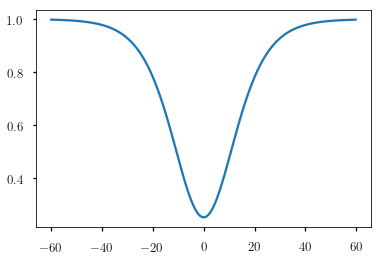

10


/Users/Carl/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


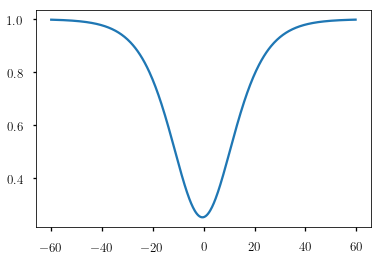

20


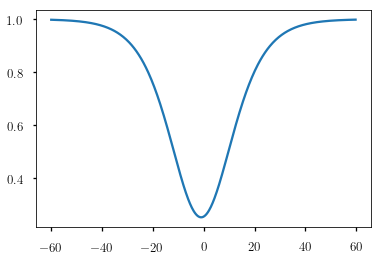

30


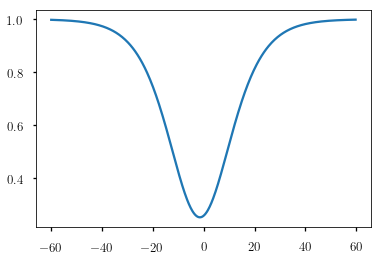

40


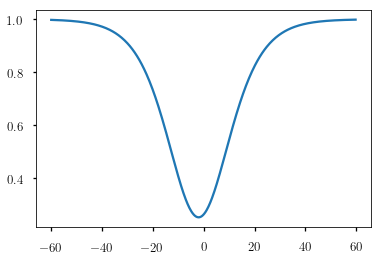

50


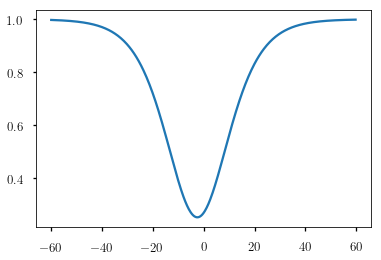

60


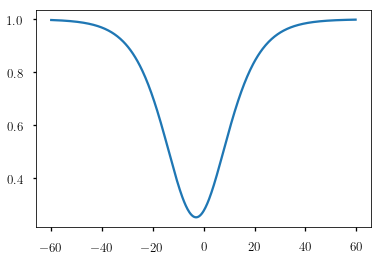

70


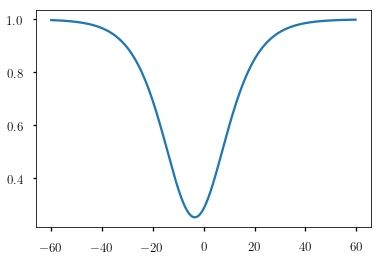

80


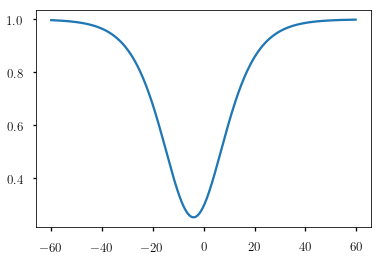

90


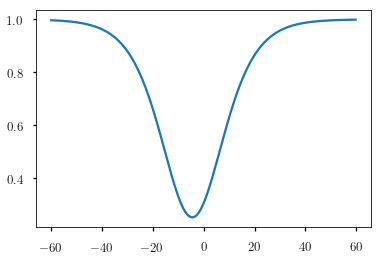

100


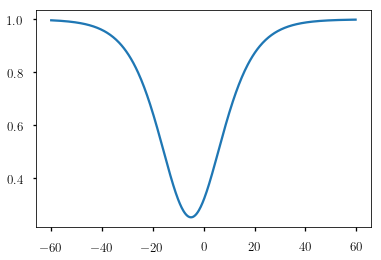

110


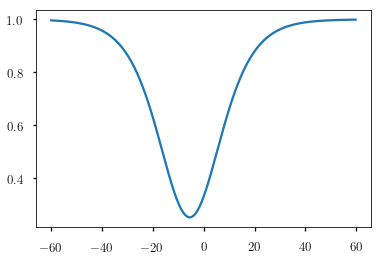

120


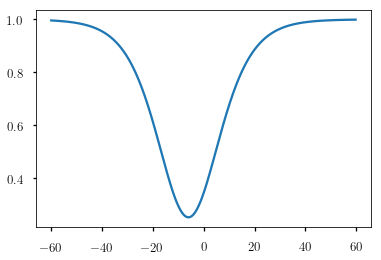

130


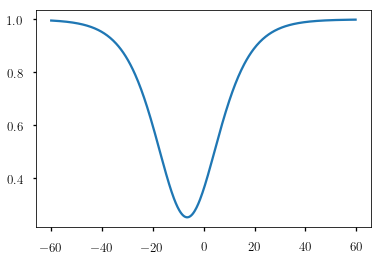

140


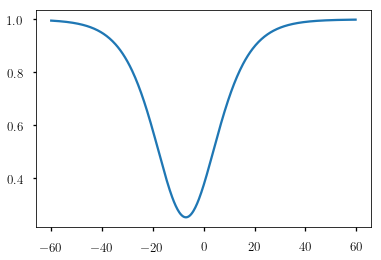

150


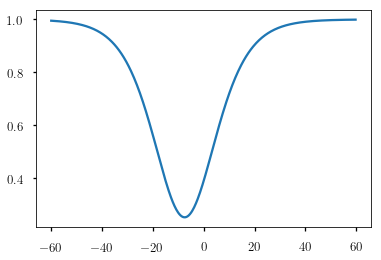

160


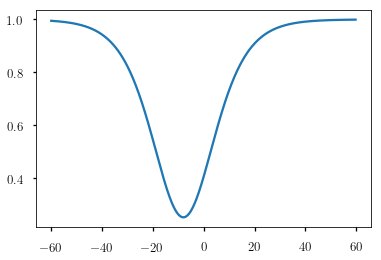

170


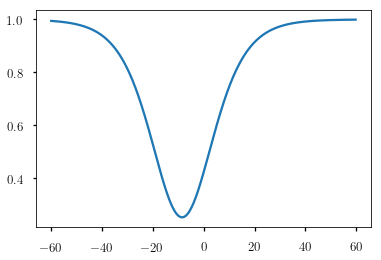

180


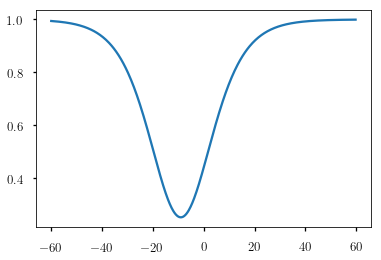

190


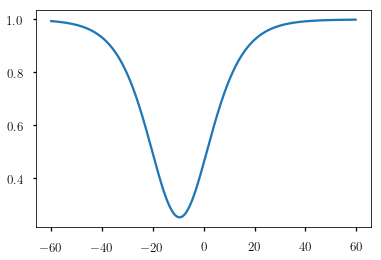

200


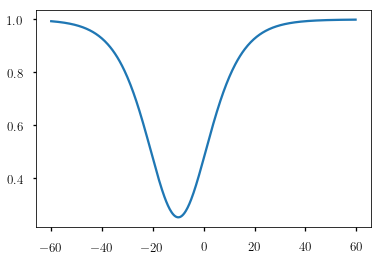

210


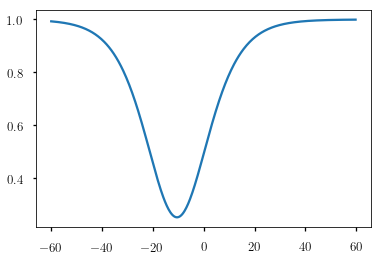

220


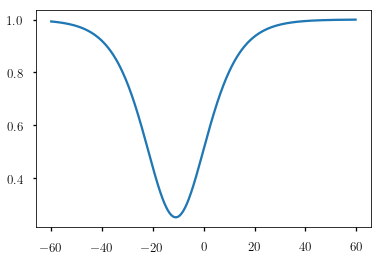

230


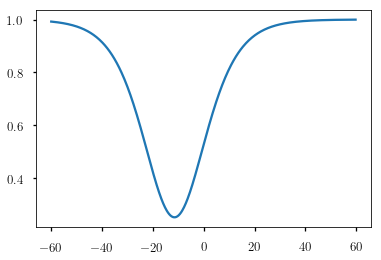

240


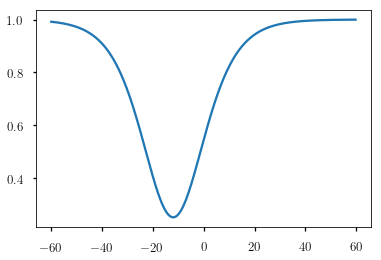

250


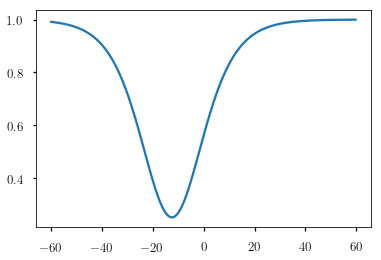

260


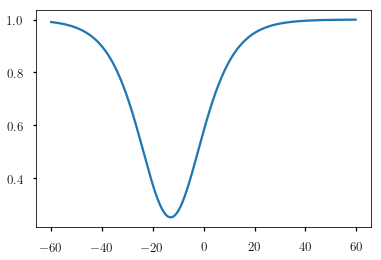

270


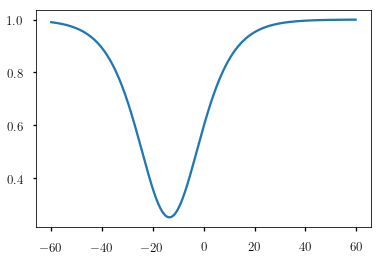

280


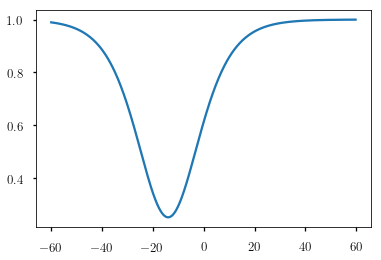

290


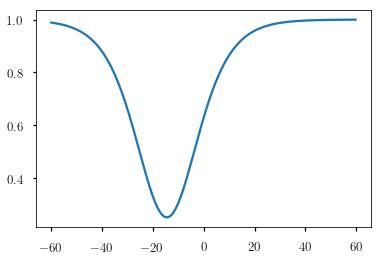

300


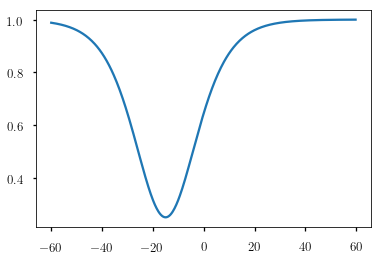

310


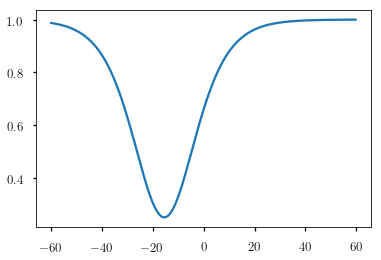

320


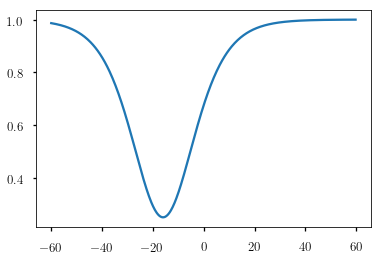

330


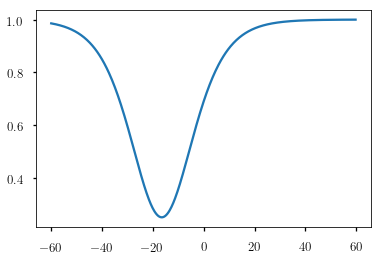

340


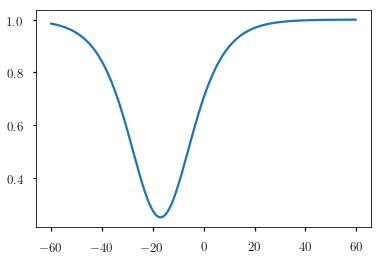

350


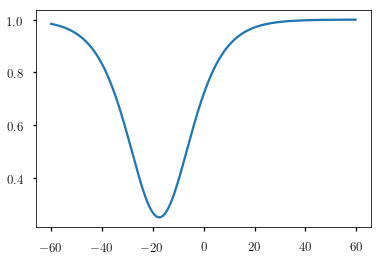

360


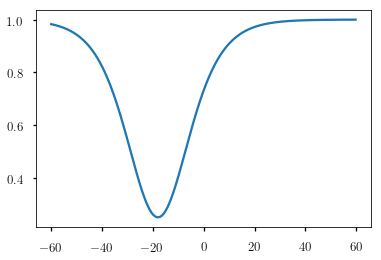

370


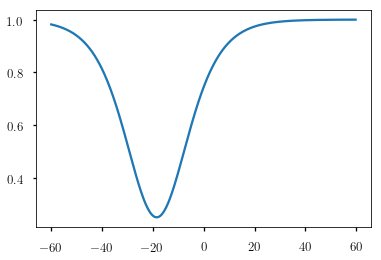

380


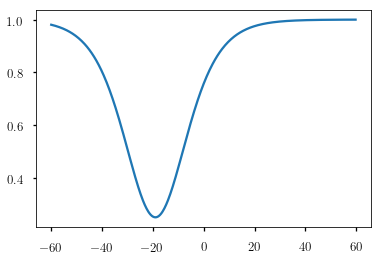

390


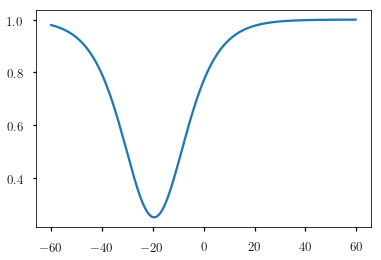

400


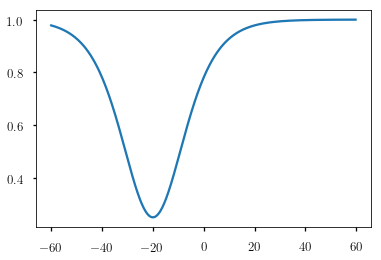

410


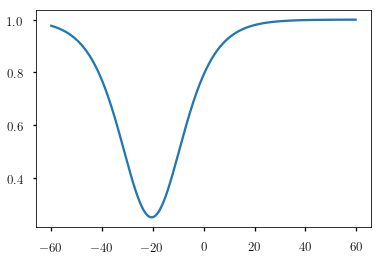

420


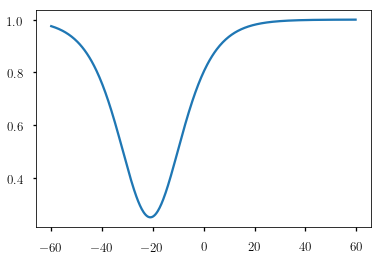

430


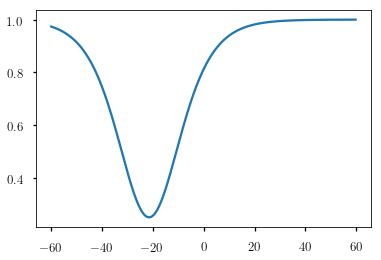

440


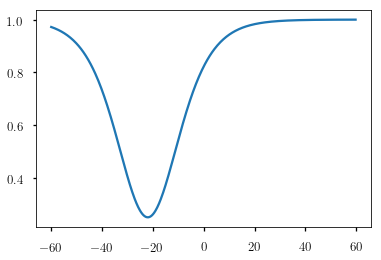

450


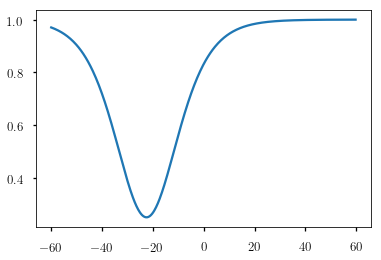

460


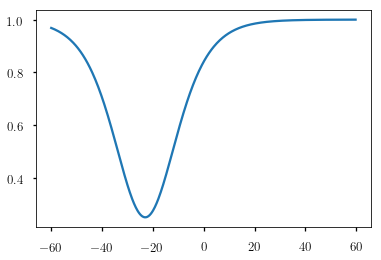

470


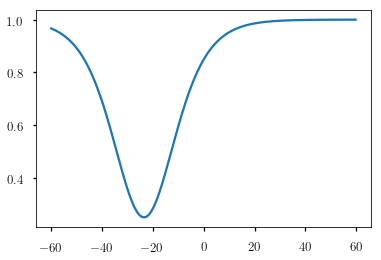

480


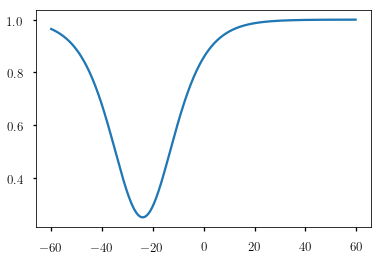

490


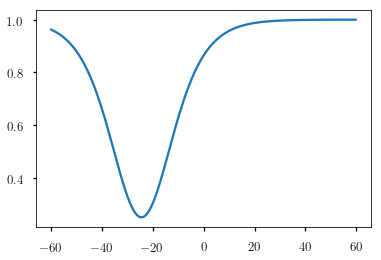

500


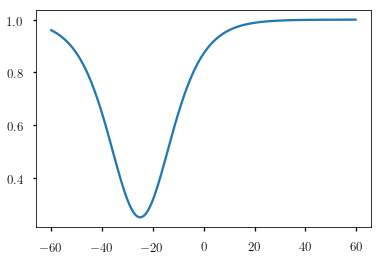

510


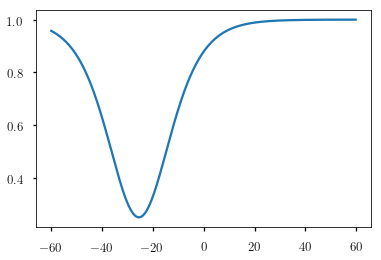

520


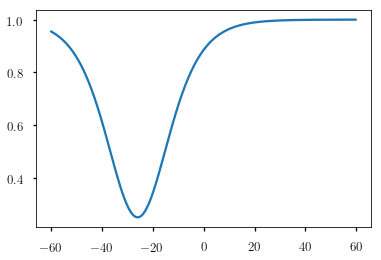

530


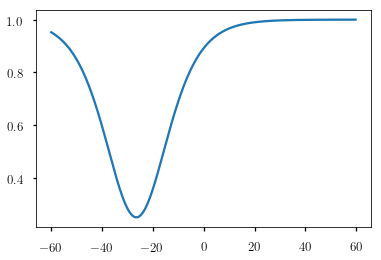

540


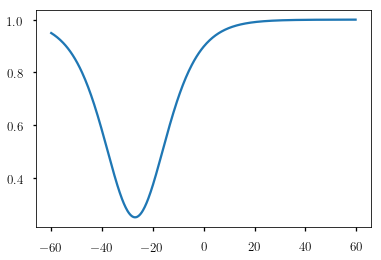

550


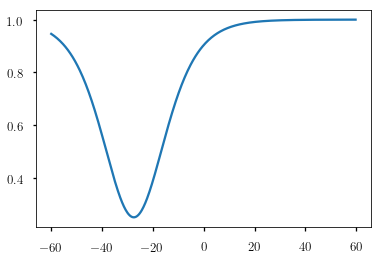

560


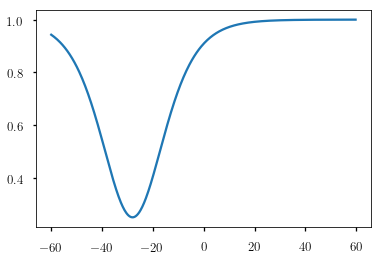

570


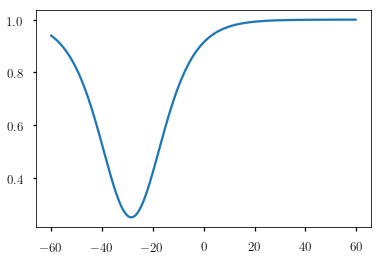

580


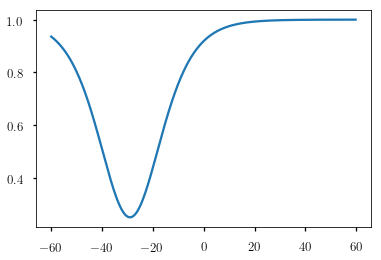

590


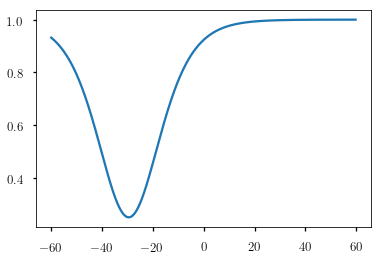

600


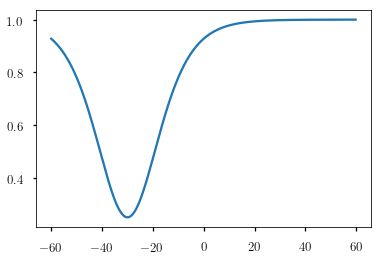

610


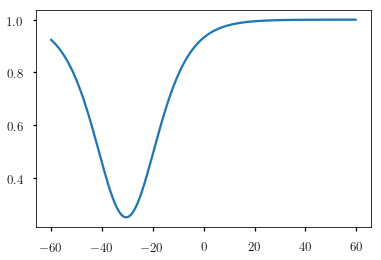

620


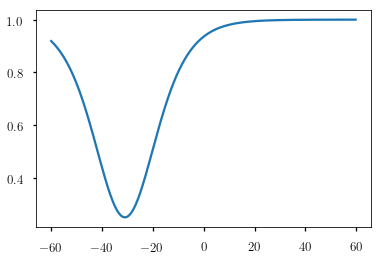

630


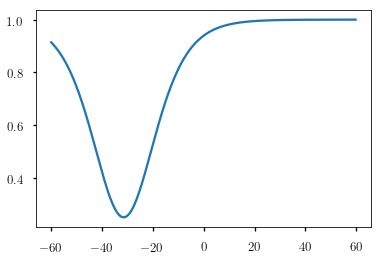

640


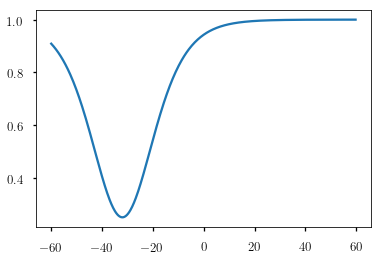

650


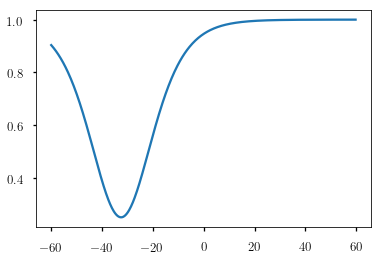

660


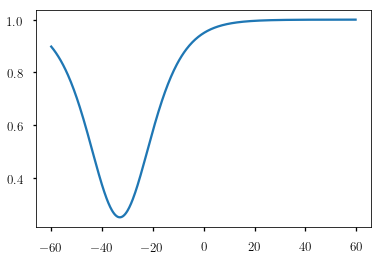

670


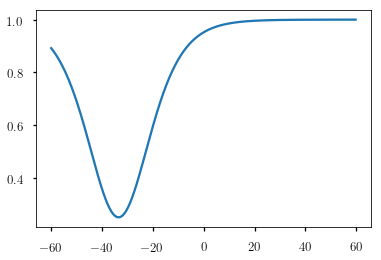

680


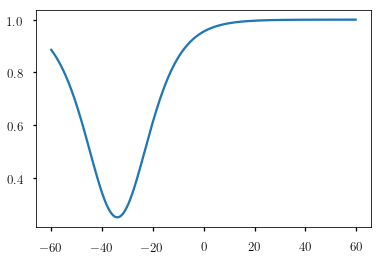

690


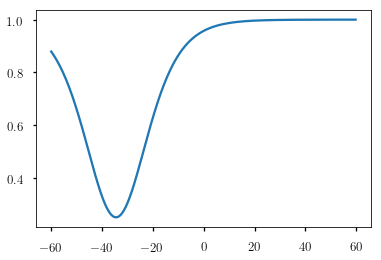

700


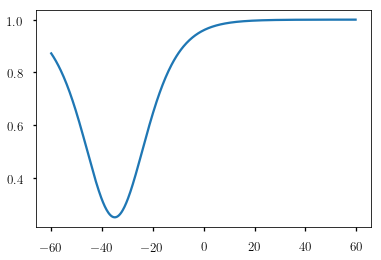

710


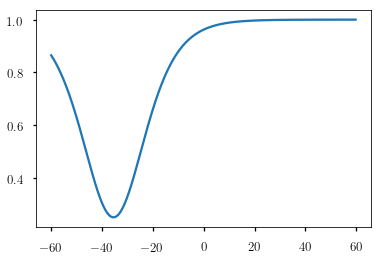

720


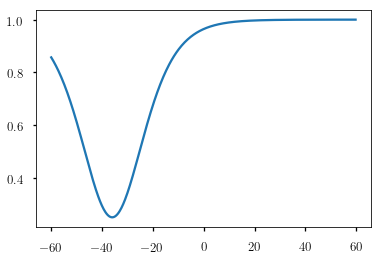

730


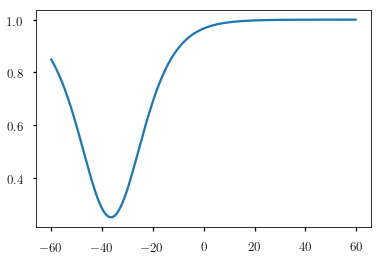

740


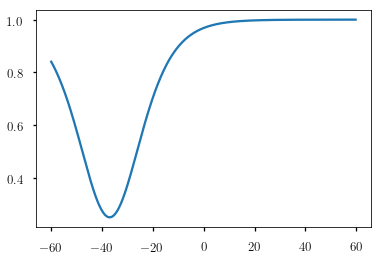

750


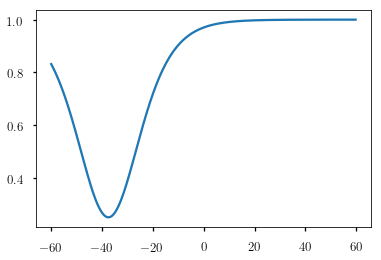

760


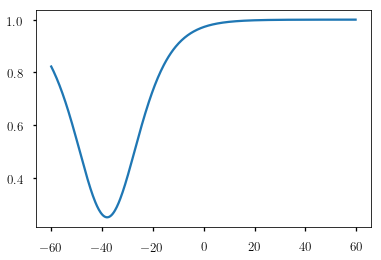

770


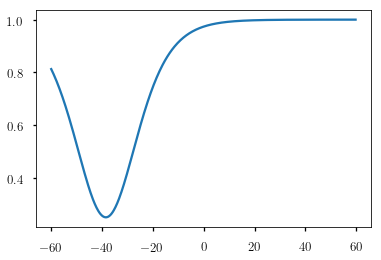

780


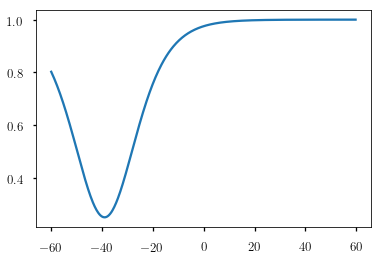

790


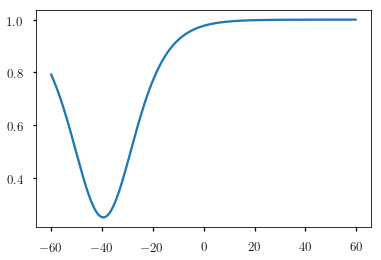

800


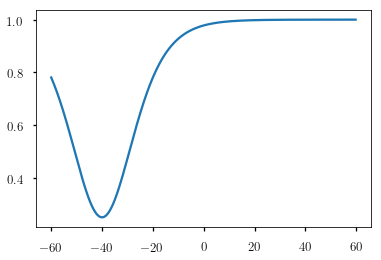

810


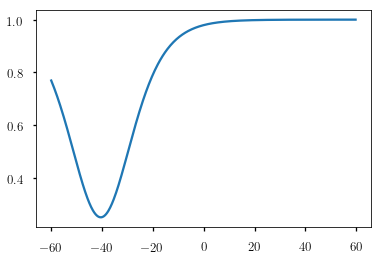

820


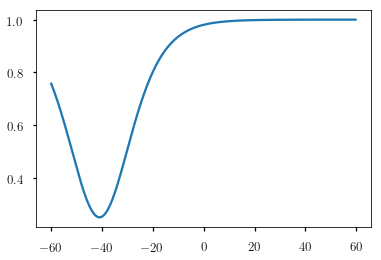

830


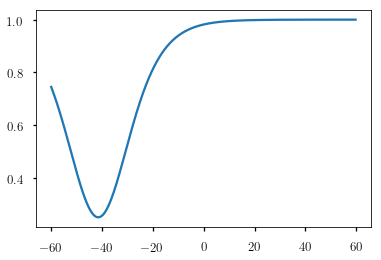

840


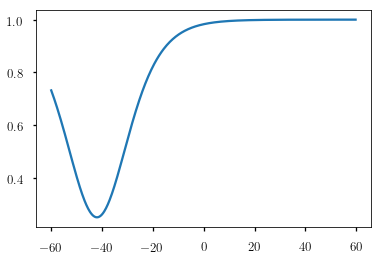

850


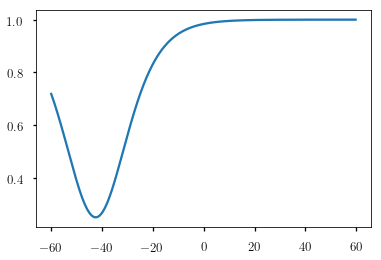

860


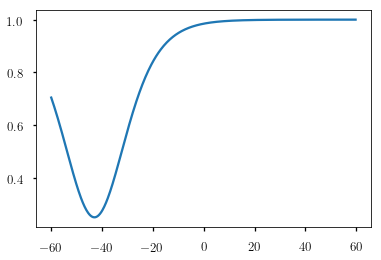

870


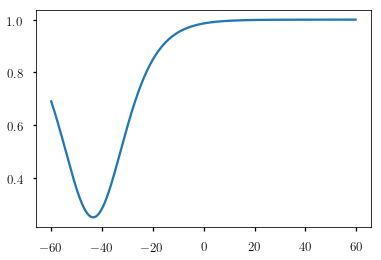

880


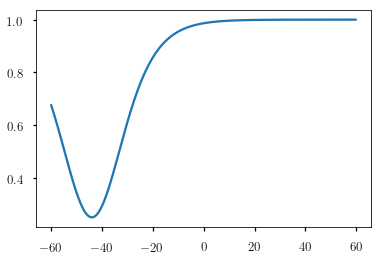

890


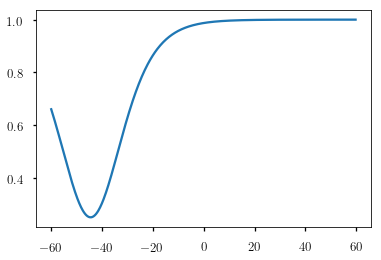

900


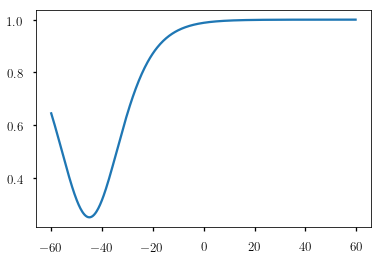

910


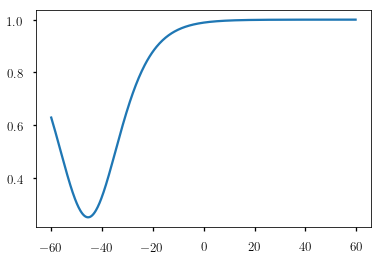

920


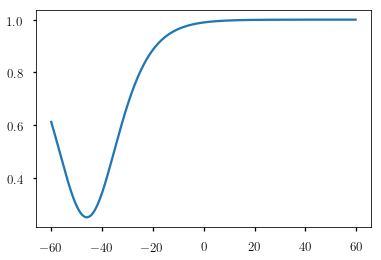

930


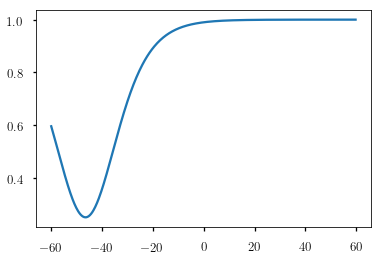

940


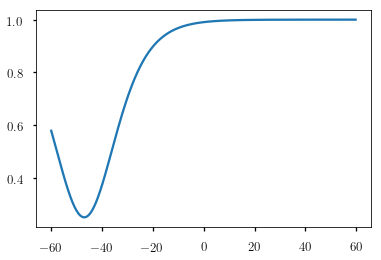

950


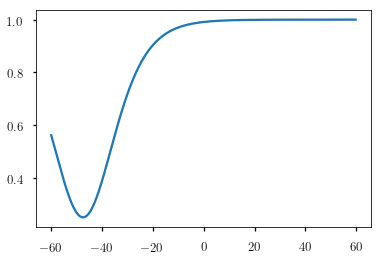

960


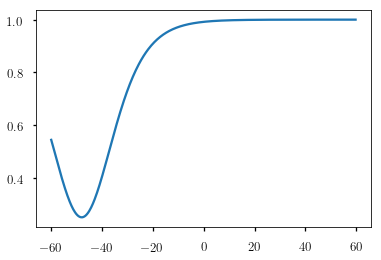

970


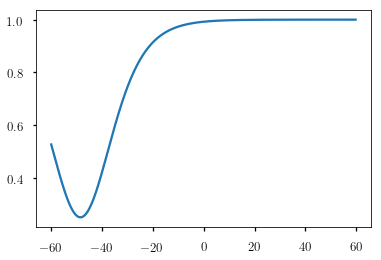

980


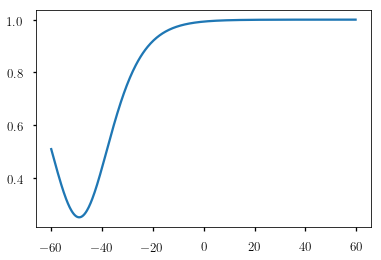

990


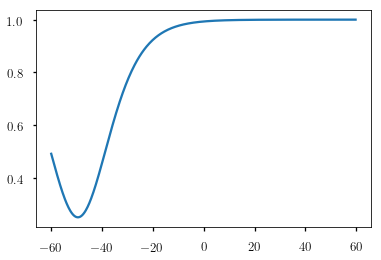

1000


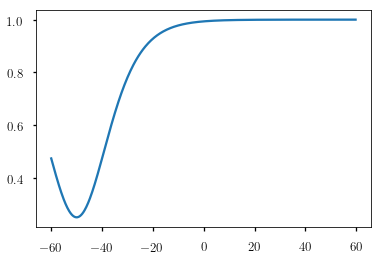

1010


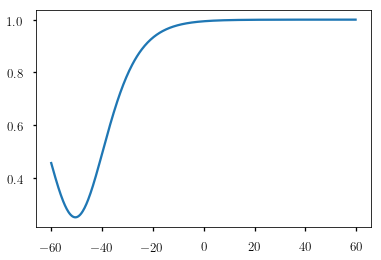

1020


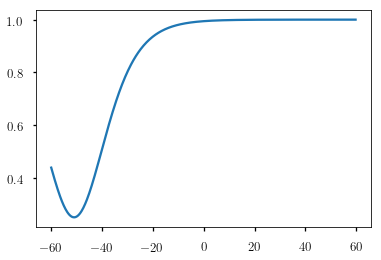

1030


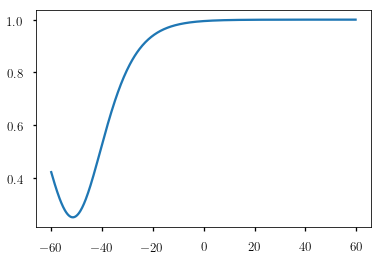

1040


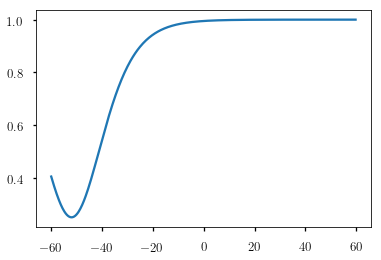

1050


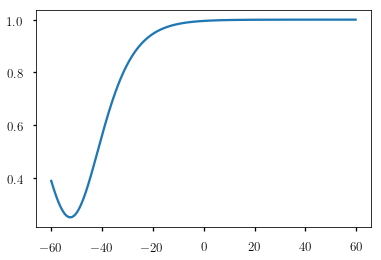

1060


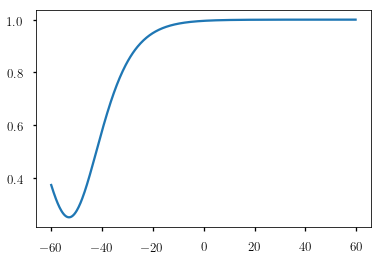

1070


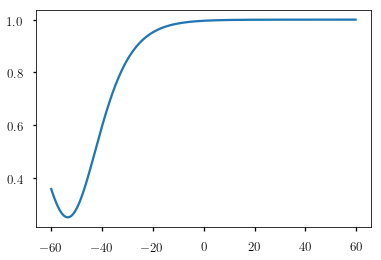

1080


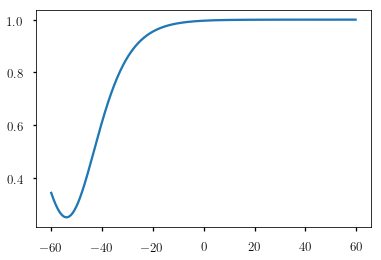

1090


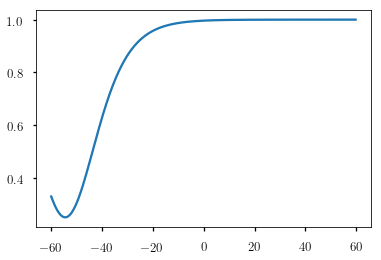

1100


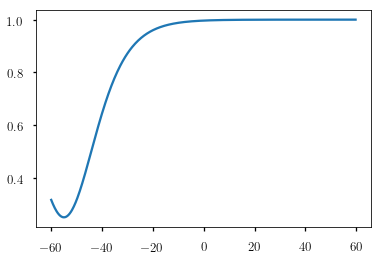

1110


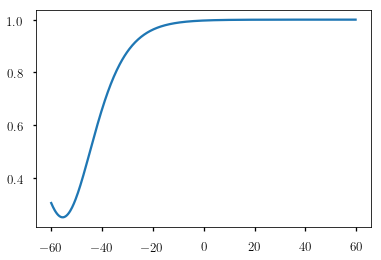

1120


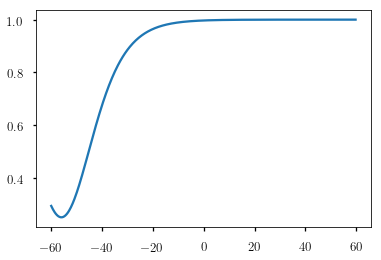

1130


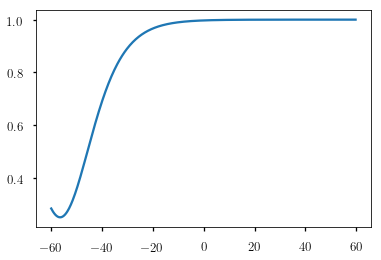

1140


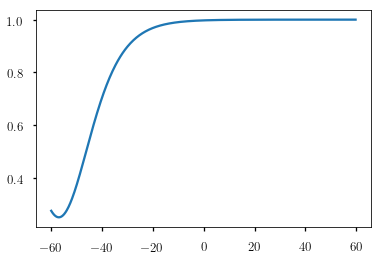

1150


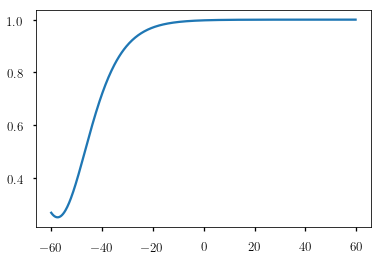

1160


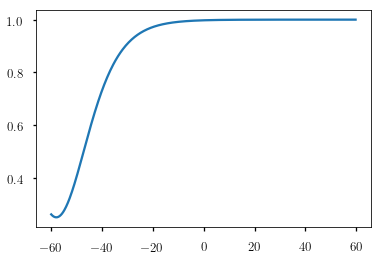

1170


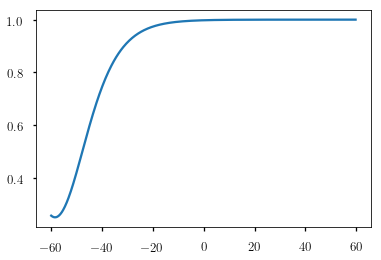

1180


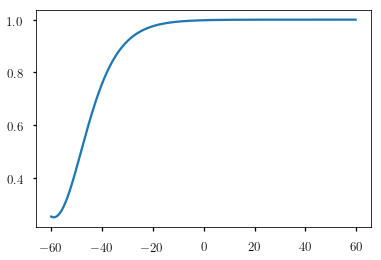

1190


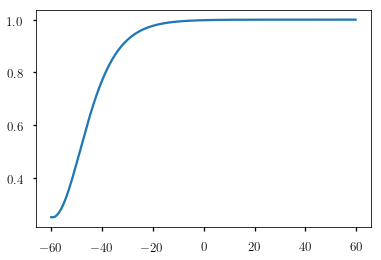

1200


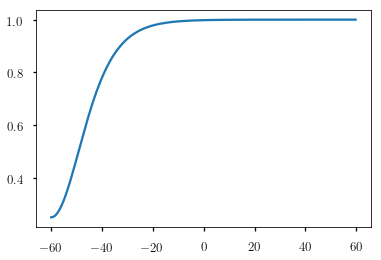

1210


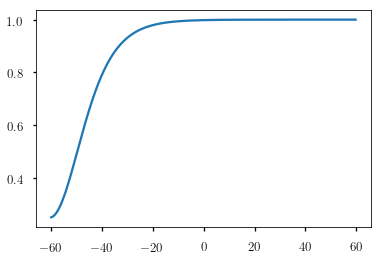

1220


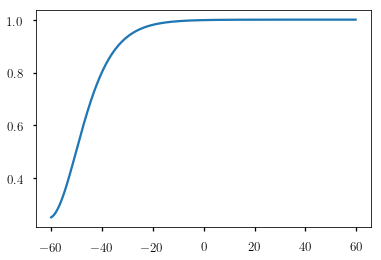

1230


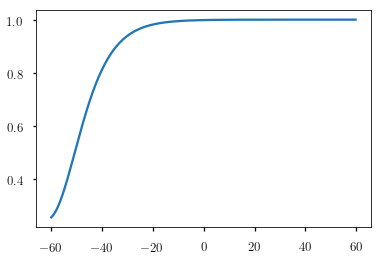

1240


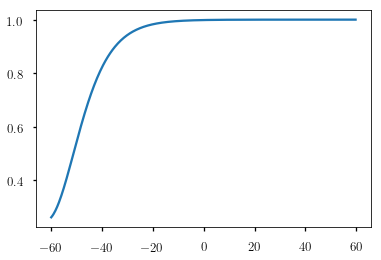

1250


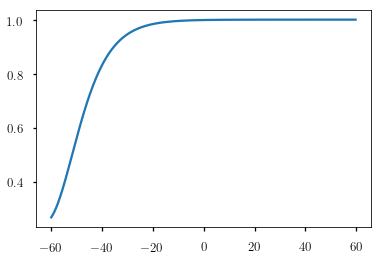

1260


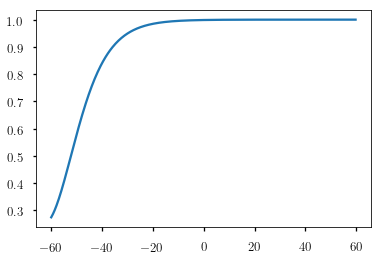

1270


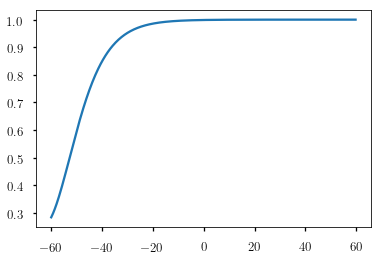

1280


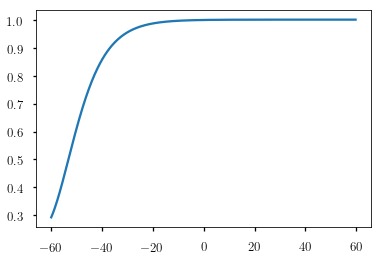

1290


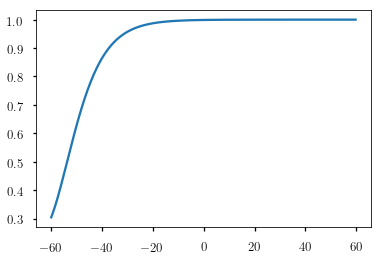

1300


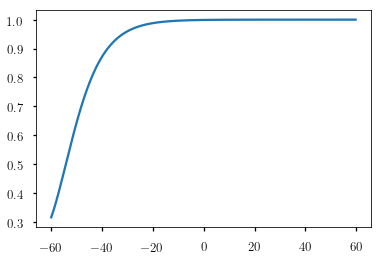

1310


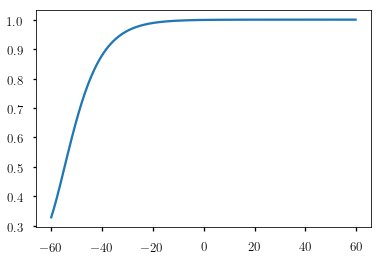

1320


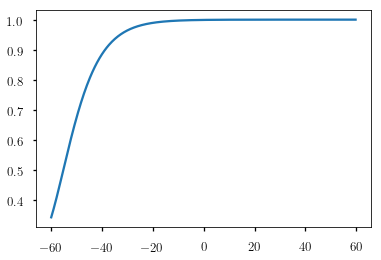

1330


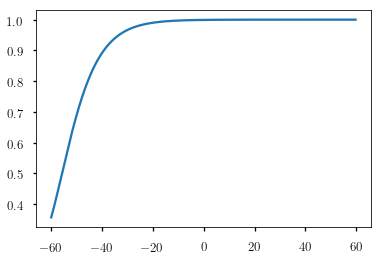

1340


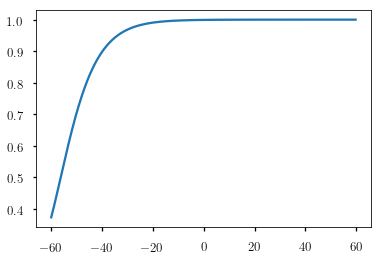

1350


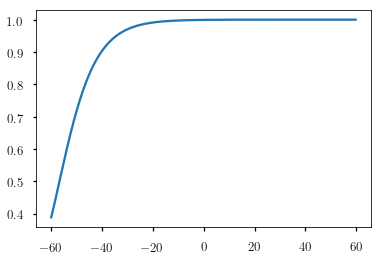

1360


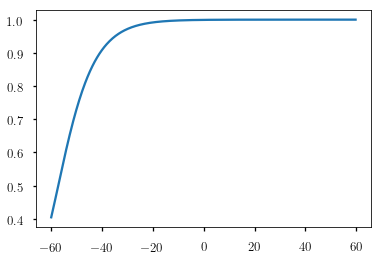

1370


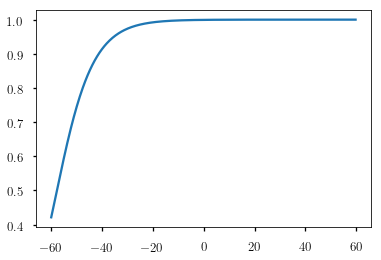

1380


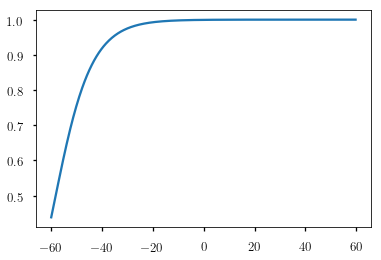

1390


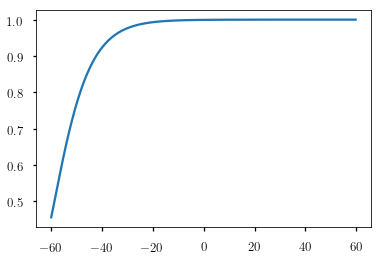

1400


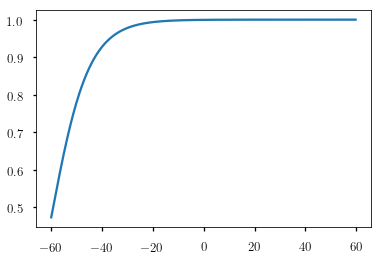

1410


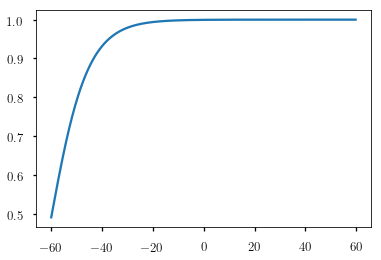

1420


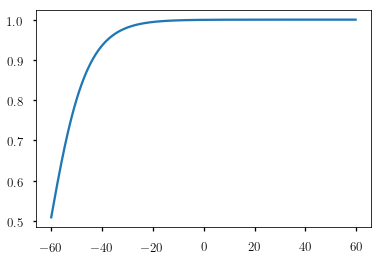

1430


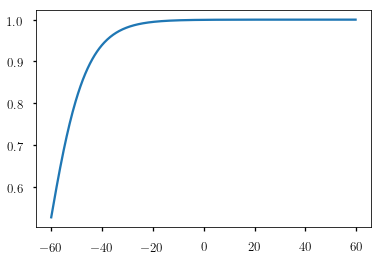

1440


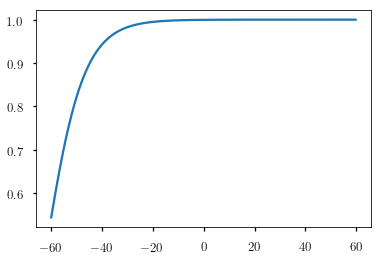

1450


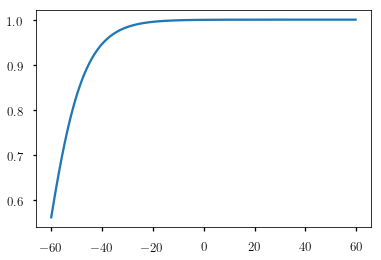

1460


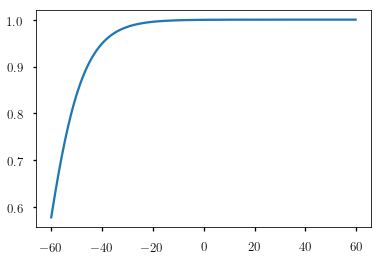

1470


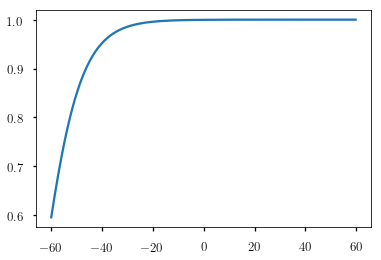

1480


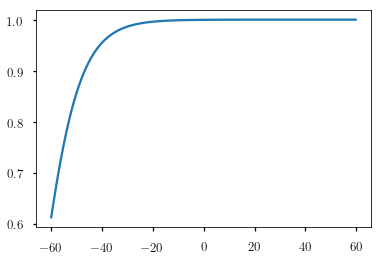

1490


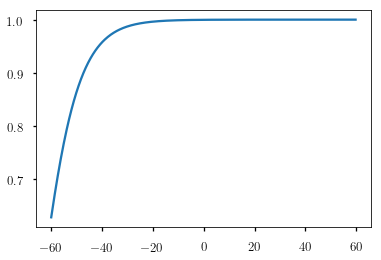

1500


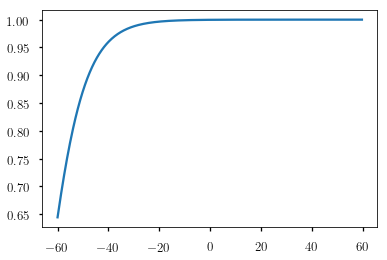

1510


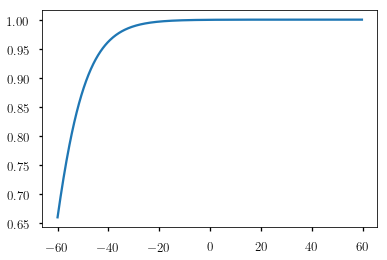

1520


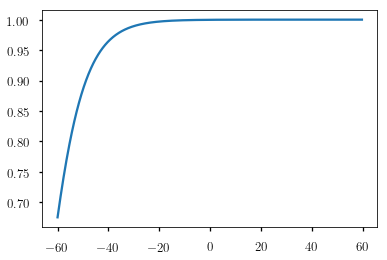

1530


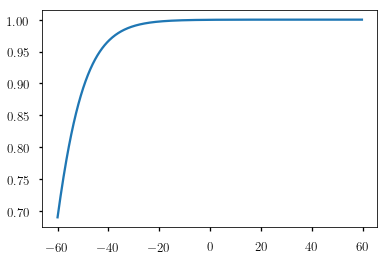

1540


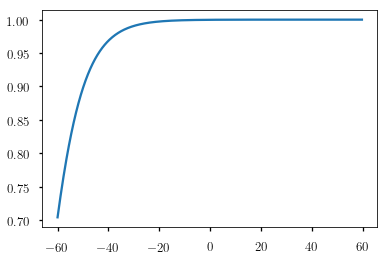

1550


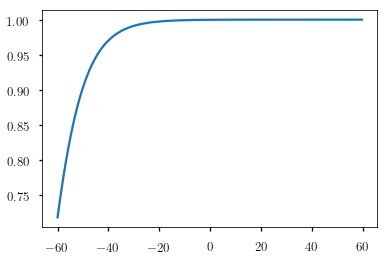

1560


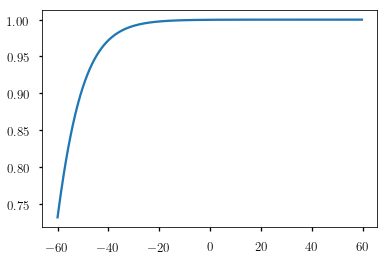

1570


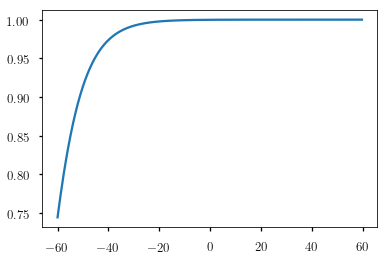

1580


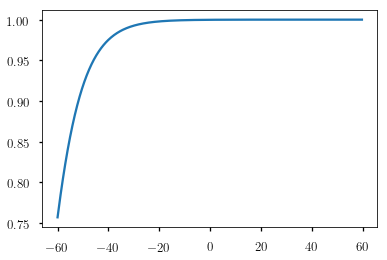

1590


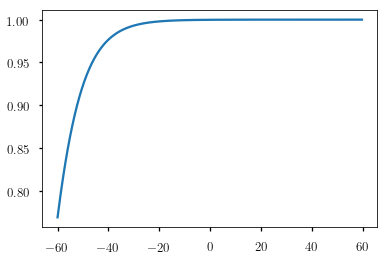

1600


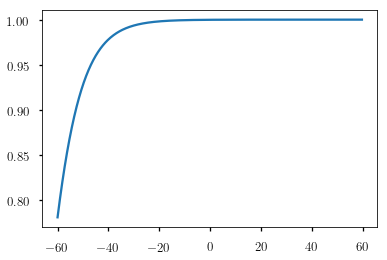

1610


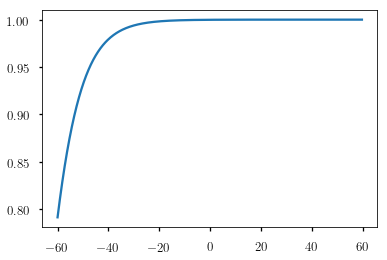

1620


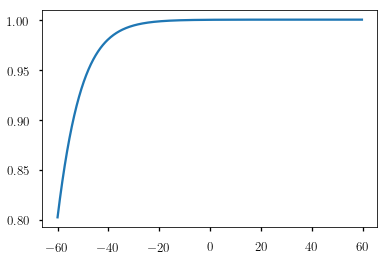

1630


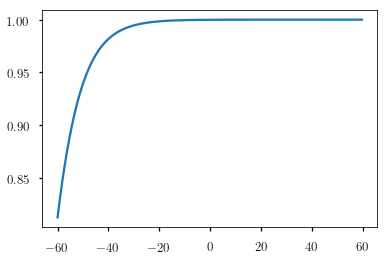

1640


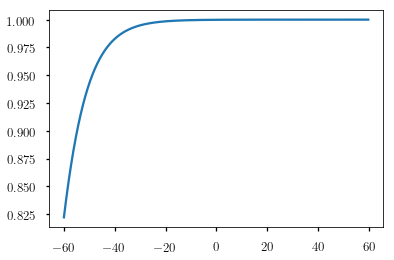

1650


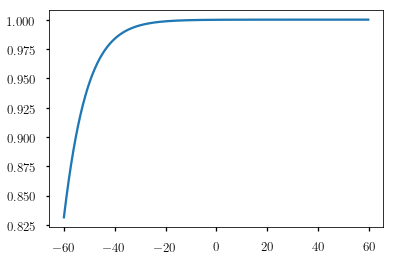

1660


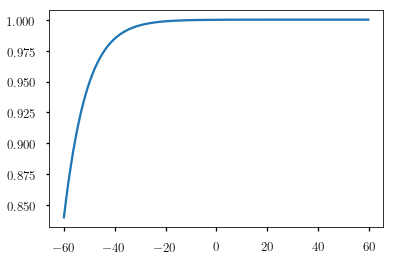

1670


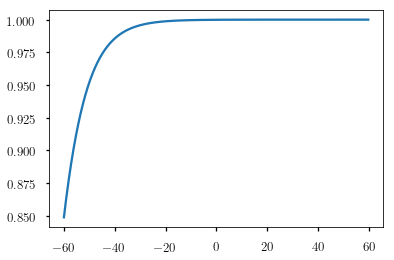

1680


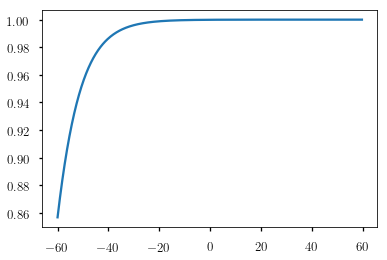

1690


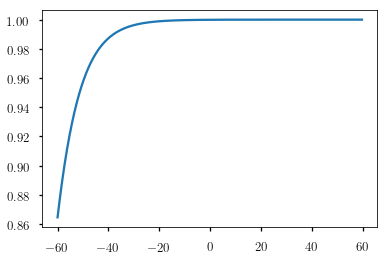

1700


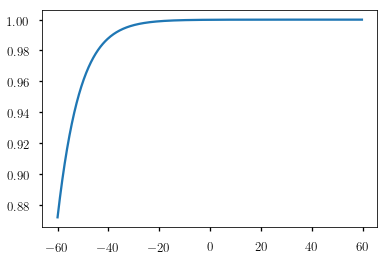

1710


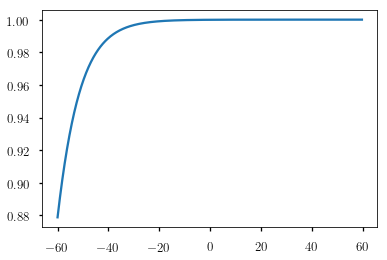

1720


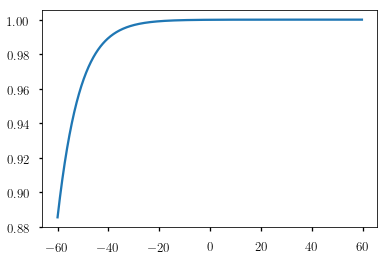

1730


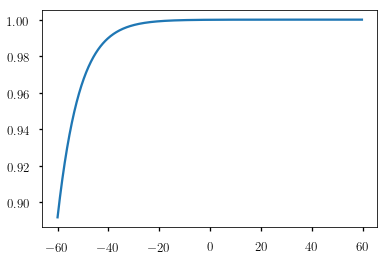

1740


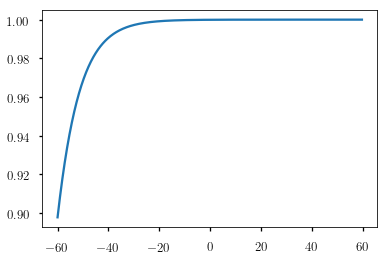

1750


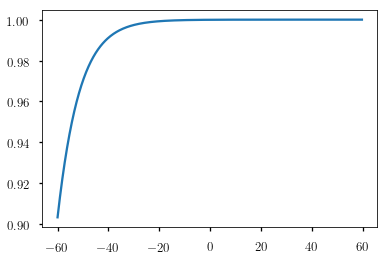

1760


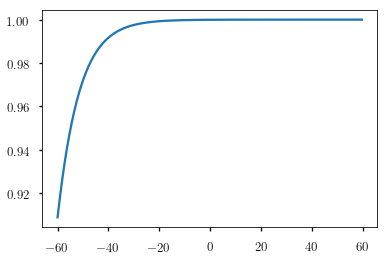

1770


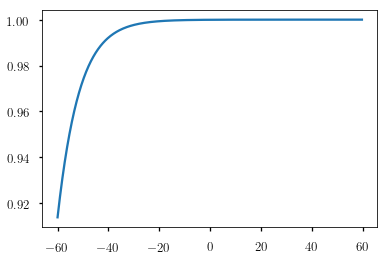

1780


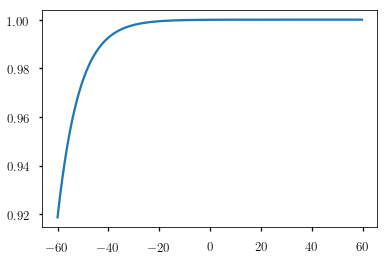

1790


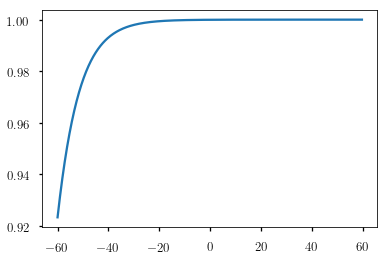

1800


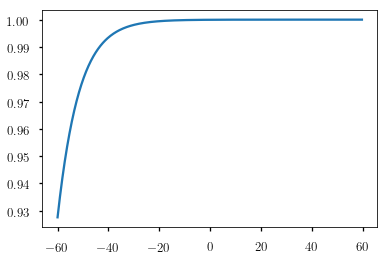

1810


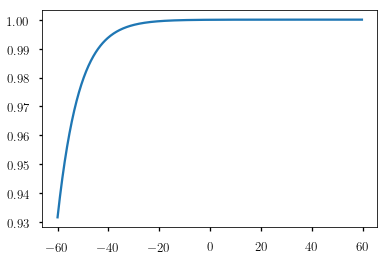

1820


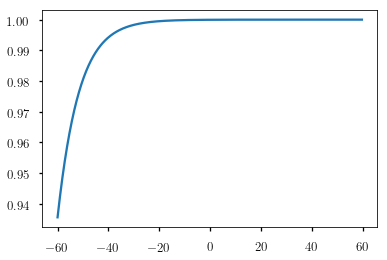

1830


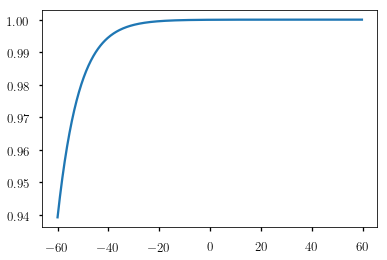

1840


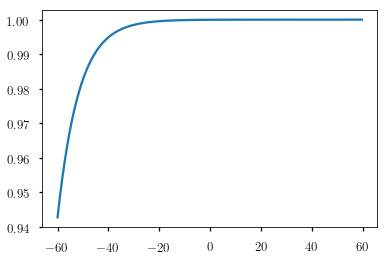

1850


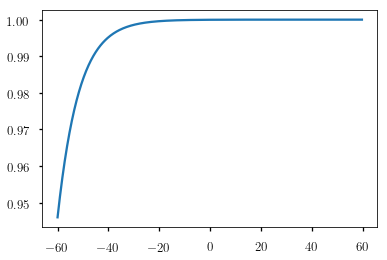

1860


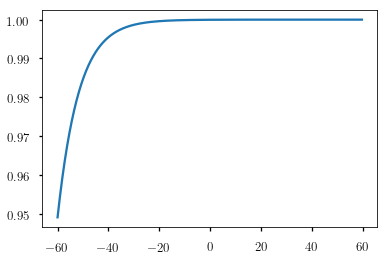

1870


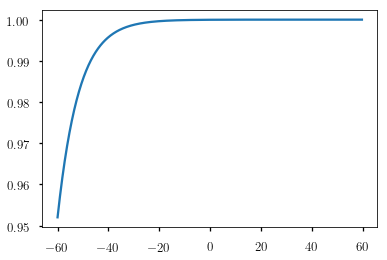

1880


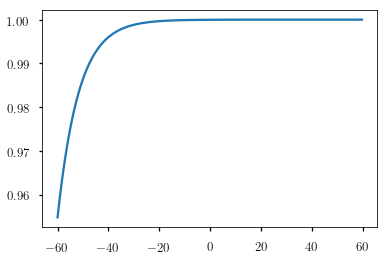

1890


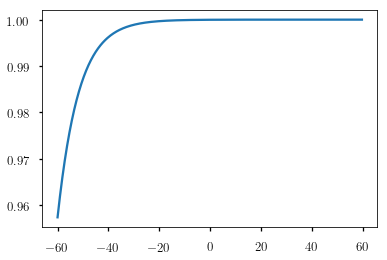

1900


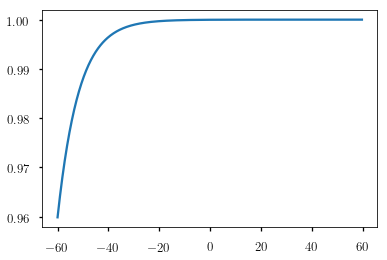

1910


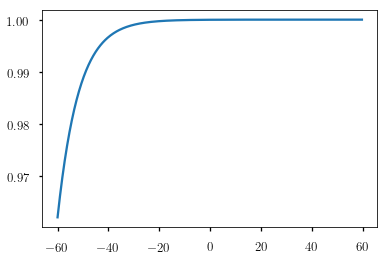

1920


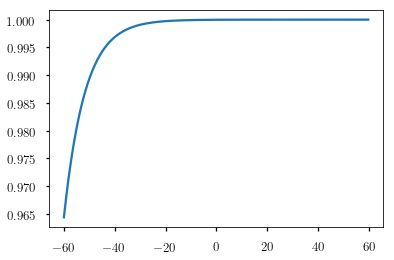

1930


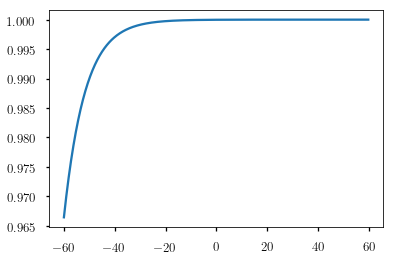

1940


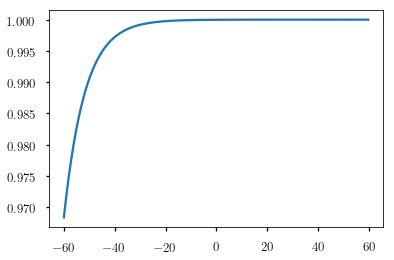

1950


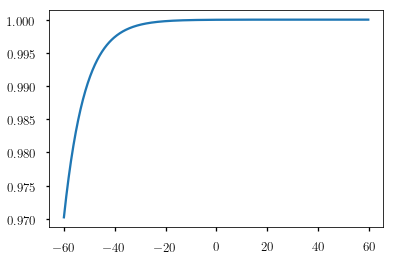

1960


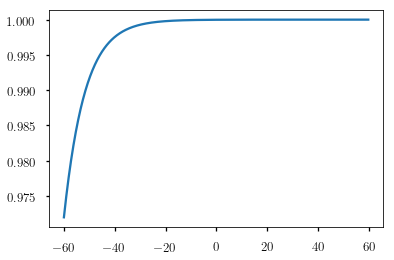

1970


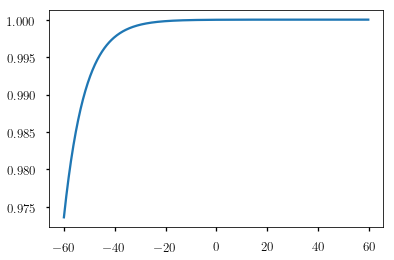

1980


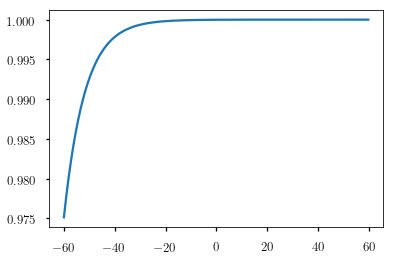

1990


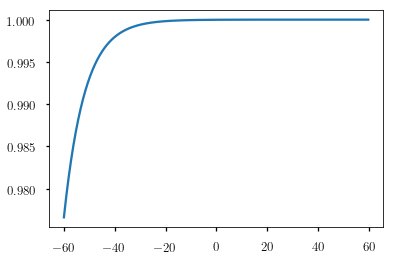

In [9]:
%matplotlib inline
nu = 0
#zrange = np.linspace(-10,10, 100)

for i in np.arange(0,2000, 10):
    print(i)
    phi = phi_nu(grid, g, nu = -0.5, t=i) #.conj()
    plt.plot(grid, phi.conj()*phi)
    plt.show()
    
    #r = np.sqrt(phi.conj()*phi)
    #sign = np.ones(len(phi))
    #sign[phi.imag < 0] = -1
    #phase = sign * np.arccos(phi.real / r)
    #plt.plot(grid, phase )

## 2) Dynamics of solitons in a homogeneous 2D Bose gas

In this part of the project we want to add some perturbations to our (now 2D) homogeneous background density and check how the dynamics of the system is affected.

In [10]:
dy = L/Ngridy

#Grid structure in in momentum-space
dky = (2*np.pi)/(len(grid)*dy)
ky = dk_x*np.arange(-Ngrid/2,Ngrid/2)

NameError: name 'Ngridy' is not defined

In [11]:
def SSFT_2D(init, V, grid):
    
    #Initialization 
    ssft_x = np.zeros((2*tsteps + 2, Ngrid), dtype=np.complex128)
    ssft_2d = np.meshgrid(ssft_1d, ssft_1d)
    
    ssft_2dk = fftshift.fft2(ssft_2dx)
    
    (ssft_2dx[0], ssft_2dx[1]) = (init, np.exp(-1j*hbar*dt*(V(grid) + g*np.abs(init)**2)/2)*init)
    (ssft_2dk[0], ssft_2dk[1]) = (fftshift(fft2(init)), fftshift(fft2(ssft_2d[1])))
    
    for t in np.arange(1,tsteps):
        ssft_2dk[2*t] = np.exp(-1j*hbar*dt*(kx**2 + ky**2)/(2*m))*ssft_2dk[2*t-1]
        ssft_2dx[2*t] = ifft2(fftshift(ssft_2dk[2*t]))
        ssft_2dx[2*t+1] = np.exp(-1j*hbar*dt*(V(grid) + g*np.abs(ssft_2dx[2*t])**2))*ssft_2dx[2*t]
        ssft_2dk[2*t+1] = fftshift(fft2(ssft_2dx[2*t+1]))
     
    #last step in momentum space and last half step in spatial coordinates
    ssft_2dk[2*tsteps] = np.exp(-1j*hbar*dt*(kx**2 + ky**2)/(2*m))*ssft_2dk[2*tsteps-1]
    ssft_2dx[2*tsteps] = ifft2(fftshift(ssft_2dk[2*tsteps]))
    ssft_2dx[2*tsteps+1] = np.exp(-1j*hbar*dt*(V(grid) + g*np.abs(ssft_2dx[2*tsteps])**2)/2)*ssft_2dx[2*tsteps]
        
    (ssft_2dx, ssft_2dk) = (np.real(ssft_2dx), np.real(ssft_2dk))
    
    return ssft_2dx, ssft_2dk



In [13]:
dt = 0.05;

xmax =64
N = 64
v = np.linspace(0, xmax, N)
dx = v[1] - v[0]
x, y = np.meshgrid(v, v)

# spectral space
kmax = 2*np.pi / dx
dk = kmax / N
#k = fftshift((arange(N)-N/2) * dk)
k = 2*np.pi*np.fft.fftfreq(N,d=dx)
kx, ky = np.meshgrid(k, k)


evolT= np.exp(-1j  * (kx**2 + ky**2) * dt / 2)
evolV= 1 # exp(-1j * (x**2 + y**2) * dt / 2)
g = 10


def splitstep(g,dt,evolT,psi):
    # apply potential
    #psi = np.exp(-1j*dt*(V))*psi
    # go to Fourier space
    psi = np.fft.fft2(psi)
    # apply kinetic part
    psi = evolT*psi
    # go back to real space
    psi=np.fft.ifft2(psi)
    psi = np.exp(-1j * dt * g * np.abs(psi)**2) * psi
    return psi

#test = splitstep(g,dt,evolT, grid2D_test)
#print(test)

In [14]:
#create a grid with homogeneous condensate background density
def create_condensed_grid(nx_grid,ny_grid,N, meshgrid = False):
    grid = np.zeros((nx_grid,ny_grid), 'complex') #initialize grid in Fourier space
    grid[0,0] = np.sqrt(N/2.) + 1j*np.sqrt(N/2.) #fill condensate mode k=0 with all particles
    grid = np.fft.fft2(grid)/np.sqrt(nx_grid*ny_grid) #Fourier transform
    if meshgrid:
        return [*np.meshgrid(np.arange(nx_grid),np.arange(ny_grid)), grid.real]
    else:
        return grid

#calculate the total number of particles on the grid
def calculate_particle_number(grid):
    return np.sum(np.sum(np.abs(grid)**2,axis=0), axis=0)

#Initializing the 2D scenario
Ngrid_x = 64
Ngrid_y = 64
N = rho * Ngrid_x * Ngrid_y

grid2D = create_condensed_grid(Ngrid_x, Ngrid_y, N, meshgrid = True)
grid2D_test = create_condensed_grid(Ngrid_x, Ngrid_y, N)

def FreePotential2D(z):
    return np.zeros(np.shape(z))

#SSFT_2D(grid2D, FreePotential2D, grid2D)

/Users/Carl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


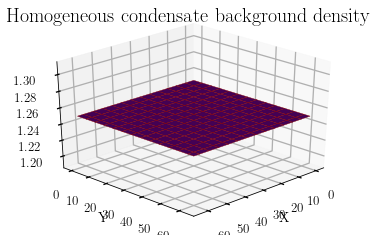

In [15]:
#Visualizing the density profile
ax = plt.axes(projection='3d')
ax.plot_surface(*grid2D, rstride=5, cstride=5,
                cmap='viridis', edgecolor='darkred')
ax.set_title('Homogeneous condensate background density', size = 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.set_zlabel(r'density profile $\rho$')
ax.view_init(30, 45)
#plt.imshow(grid2D.real)

NameError: name 'test' is not defined

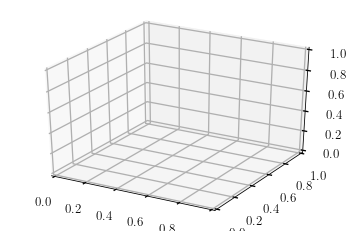

In [16]:
#Visualizing the density profile
ax = plt.axes(projection='3d')
ax.plot_surface(*grid2D[:2], test.real, rstride=5, cstride=5,
                cmap='viridis', edgecolor='darkred')
ax.set_title('Homogeneous condensate background density', size = 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.set_zlabel(r'density profile $\rho$')
ax.view_init(30, 45)
#plt.imshow(grid2D.real)

Text(0, 0.5, 'y')

/Users/Carl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


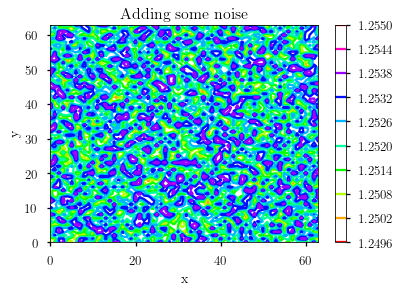

In [17]:
%matplotlib inline

#Rauschen

init2D =  create_condensed_grid(Ngrid_x, Ngrid_y, N)
#print(min(init2D.flat))
init2D +=  0.0883883476483 * np.random.random(np.shape(init2D)) / 20


#Visualizing the density profile
plt.contour(init2D.real, cmap='hsv')
plt.colorbar()
plt.title('Adding some noise', size = 16)
plt.xlabel('x')
plt.ylabel('y')

In [18]:
noise_evol = [init2D]

for t in range(tsteps):
    noise_evol.append(splitstep(g, dt, evolT, noise_evol[t]))

<IPython.core.display.Javascript object>


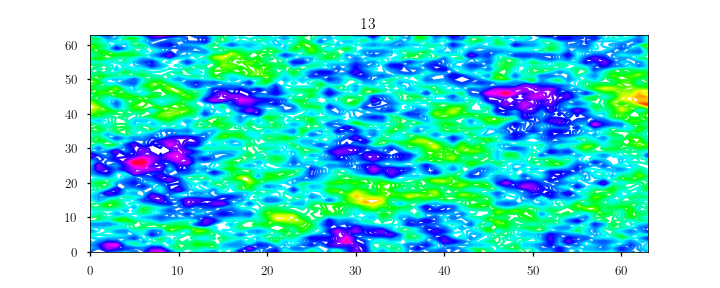

In [24]:
%matplotlib notebook
plt.rcParams["figure.figsize"][0] = 10

def update_contour_plot(t):
    #fig.clf()
    ax.cla()
    im = ax.contour(noise_evol[t].real, 50, cmap = "hsv")
    plt.title(str(t))
    #fig.colorbar(im, ax = ax)
    return im,

fig = plt.figure()
im = plt.contour(init2D.real, 50, cmap='hsv')
ax = fig.gca()
ani = animation.FuncAnimation(fig, update_contour_plot,
                               frames=np.arange(0,tsteps,1), # t-values and steps
                               interval=100, # wait time before displaying new frame in ms
                               blit = True)
#plt.colorbar(im)

plt.show()


## 3) Topological defects: Studying the behaviour of vortices in a 2D gas

In 2D other topological defects, called vortices can be present. The given routine initializes a 2D gas containing vortices (and anti-vortices). Our goal is to visualize and analyze their dynamics for different initial vortex distributions. 

### Tools for the vortex grids 

In [20]:
#Vortex with winding number n = +- 1
def add_2d_vortex_simple(grid, x_pos, y_pos, n, N, g):
    grid_h = grid
    f0 = np.sqrt(1.*N/(grid.shape[0]*grid.shape[1]))
    #print(f0**2)
    xi = 1./(2*f0*np.sqrt(g))
    #print(xi)
    for x2 in np.arange(0,grid.shape[0]):
        for y2 in np.arange(0,grid.shape[1]):
            rho = x_pos-x2 + 1j*n*(y_pos-y2)        ### shape of the vortex, rho = 0 at the core, i.e. if x_pos = x2 and y_pos = y2
            grid_h[x2,y2] *= (1.0/ xi / np.sqrt(2. + np.abs(rho)**2/xi/xi)) * rho    #### multiply homogeneous background field with shape of vortex        
    return grid_h

#Vortex with winding number n  
def add_2d_vortex_simple_n(grid, x_pos, y_pos, n, N, g):
    grid_h = grid
    f0 = np.sqrt(1.*N/(grid.shape[0]*grid.shape[1]))
    #print(f0**2)
    xi = 1./(2*f0*np.sqrt(g))
    #print xi

    sn = (int) (n/np.sqrt(n*n))
    wn = (int) (np.sqrt(n*n))
    
    for x2 in np.arange(0,grid.shape[0]):
        
        for y2 in np.arange(0,grid.shape[1]):
            
            rho = x_pos-x2 + 1j*sn*(y_pos-y2)
            rho *= (1.0/ xi / np.sqrt(2. + np.abs(rho)**2/xi/xi))
            rho = rho**wn
            
            grid_h[x2,y2] *= rho
        
    return grid_h


def add_2d_vortex(grid, x_pos, y_pos, n, N, g):
    """ 
    add a single vortex to the grid 
    @params:
    grid : numerical real space grid
    x_pos : x-position of vortex
    y_pos : y-9position of vortex
    n : quantization of vortex
    N : total particle number
    g : non-linear coupling
    """
    grid_h = grid
    if((int) (np.sqrt(n*n)) == 1):

        print("Only single quantized vortices")
        
        grid_h = add_2d_vortex_simple(grid_h, x_pos, y_pos, n, N, g)
        
        #Adding "mirror vortices" on all 8 adjacent cells to respect periodic boundaries:
        grid_h = add_2d_vortex_simple(grid_h, x_pos+grid.shape[0], y_pos, n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos+grid.shape[0], y_pos-grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos, y_pos-grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos-grid.shape[0], y_pos-grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos-grid.shape[0], y_pos, n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos-grid.shape[0], y_pos+grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos, y_pos+grid.shape[1], n, N, g)
        grid_h = add_2d_vortex_simple(grid_h, x_pos+grid.shape[0], y_pos+grid.shape[1], n, N, g)

    else:

        print("Vortices with higher quantization")
        
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos, y_pos, n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos+grid.shape[0], y_pos, n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos+grid.shape[0], y_pos-grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos, y_pos-grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos-grid.shape[0], y_pos-grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos-grid.shape[0], y_pos, n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos-grid.shape[0], y_pos+grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos, y_pos+grid.shape[1], n, N,g)
        grid_h = add_2d_vortex_simple_n(grid_h, x_pos+grid.shape[0], y_pos+grid.shape[1], n, N,g)
        
    return grid_h

def create_2d_random_vortexpair_grid(nx_grid,ny_grid,num_vortex_pairs,N,g):
    """
    Function creates a grid with randomly placed singly quantized vortices, equal number of vortices with n=1 and antivortices with n=-1
    @params:
    nx_grid : number of grid points in x-direction
    ny_grid : number of grid points in y-direction
    num_vortex_pairs : number of vortex pairs with quantization n= +-1 on the grid
    N : total particle number
    g : non-linear coupling
    """
    
    grid = create_condensed_grid(nx_grid, ny_grid,N)

    for i in np.arange(0,num_vortex_pairs):

        grid = add_2d_vortex(grid, nx_grid*np.random.random(), ny_grid*np.random.random(), 1, N ,g)
        grid = add_2d_vortex(grid, nx_grid*np.random.random(), ny_grid*np.random.random(), -1, N ,g)

    return grid


def create_2d_random_vortex_grid(nx_grid,ny_grid,num_vortices,n,N,g):
    """
    function creates a grid with randomly placed n-quantized vortices, equal quantization of all vortices 
    """
    grid = create_condensed_grid(nx_grid, ny_grid,N)

    for i in np.arange(0,num_vortices):

        grid = add_2d_vortex(grid, nx_grid*np.random.random(), ny_grid*np.random.random(), n, N ,g)

    return grid

def create_2d_regular_vortex_grid(nx_grid,ny_grid,lx,ly,n,N,g):
    """
    Function creates a grid with a regular vortex configuration, vortices can also be highly quantized (n>1 or n<-1), arrangement in a checkerboard manner, i.e. vortices would correspond
    for example to black fields and antivortices to white fields of a checkerboard
    @params:
    nx_grid : number of grid points in x-direction
    ny_grid : number of grid points in y-direction
    lx : number of defects in x-direction of checkerboard
    ly : number of defects in y-direction of checkerboard
    n : quantization of the vortices
    N : total particle number
    g : non-linear coupling
    """
    
    grid = create_condensed_grid(nx_grid, ny_grid,N)

    dist_x = 1.*nx_grid/lx
    dist_y = 1.*ny_grid/ly

    print(dist_x)
    
    sy = 1
    for x in np.arange(1,lx+1):

        sx = 1
        for y in np.arange(1,ly+1):

            grid = add_2d_vortex(grid, dist_x*x, dist_y*y, sy*sx*n, N,g)
            sx *= -1

        sy*= -1

    return grid

### Initializing the vortex grids

In [21]:
def main(argv):
    """
    Main program to initialize a vortex grid
    """
    do_random_vortexpair_grid = False     ### if True initial grid will be vortex grid with an equal number of vortices and antivortices placed at random positions
    do_random_vortex_grid = True       ### if True initial grid will be vortex grid composed of vortices with equal quantization placed at random positions
    do_regular_vortex_grid = False        ### if True initial grid will be regular vortex grid, i.e. equal distances between vortices and antivortices
    
    nx_grid = 64    ### number of grid points in x-direction
    ny_grid = 64    ### number of grid points in y-direction

    xi = 4          ### healing length, resolved with 4 grid points, if you use a small grid you can go down to 2 grid points
    g = 1e-2        ### non-linear GPE coupling
    rho = 1./(2*g*xi**2)    ### homogeneous background density
    print("Homogeneous background density:" , rho)
    
    N = rho*nx_grid*ny_grid   ### total particle number of simulation
    print("Particle number: " , N)

    if(do_random_vortexpair_grid):

        num_vortex_pairs = 6     ### number of vortex pairs with quantization n = +-1 
        grid = create_2d_random_vortexpair_grid(nx_grid,ny_grid, num_vortex_pairs, N,g)

    if(do_random_vortex_grid):

        num_vortices = 10     ### total number of vortices
        n = 2                 ### quantization of vortices
        grid = create_2d_random_vortex_grid(nx_grid,ny_grid, num_vortices,n, N,g)

    if(do_regular_vortex_grid):
        lx = 2     ### number of vortices in x-direction on checkerboard
        ly = 2     ### number of vortices in y-direction on checkerboard
        n = 4      ### quantization of the vortices 
        grid = create_2d_regular_vortex_grid(nx_grid, ny_grid, lx, ly, n, N, g)

        
    grid *= np.sqrt(1.*N/calculate_particle_number(grid))    ### normalize to initially set particle number
    print("Particle number on created vortex grid: " , calculate_particle_number(grid))
    return grid
    
    
if __name__=='__main__':
    tmp = main(sys.argv)

Homogeneous background density: 3.125
Particle number:  12800.0
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Vortices with higher quantization
Particle number on created vortex grid:  12800.0


In [22]:
dt = 0.05;

xmax =64
N = 64
v = np.linspace(0, xmax, N)
dx = v[1] - v[0]
x, y = np.meshgrid(v, v)

# spectral space
kmax = 2*np.pi / dx
dk = kmax / N
#k = fftshift((arange(N)-N/2) * dk)
k = 2*np.pi*np.fft.fftfreq(N,d=dx)
kx, ky = np.meshgrid(k, k)


evolT= np.exp(-1j  * (kx**2 + ky**2) * dt / 2)
evolV= 1 # exp(-1j * (x**2 + y**2) * dt / 2)
g = 10

<IPython.core.display.Javascript object>


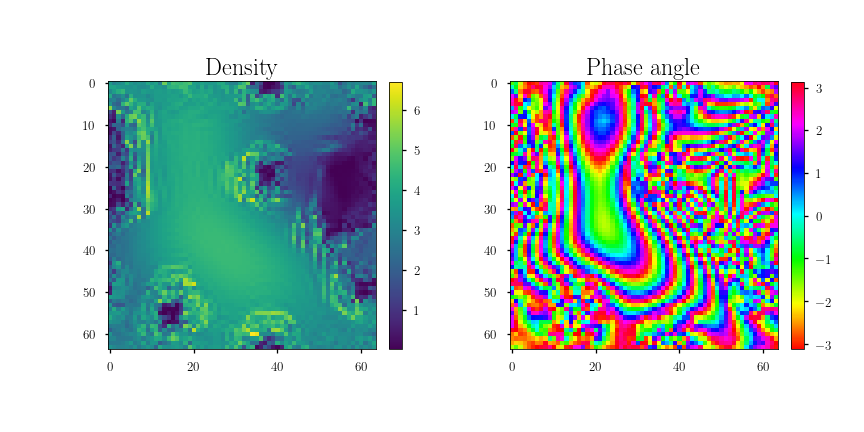

In [25]:
%matplotlib notebook
grid = tmp

myfig, myaxes = plt.subplots(1, 2, figsize = (12, 6))
plt.gcf().subplots_adjust(wspace = 0.5)
myaxes[0].set_title('Density', size = 24)
myim0 = myaxes[0].imshow(np.abs(grid)**2)
mycax0 = myfig.add_axes([0.45, 0.191, 0.015, 0.62])
myfig.colorbar(myim0, cax = mycax0, ax = myaxes[0])

myaxes[1].set_title('Phase angle', size = 24)
myim1 = myaxes[1].imshow(np.angle(grid), cmap = 'hsv')
mycax1 = myfig.add_axes([0.915, 0.191, 0.015, 0.62])
myfig.colorbar(myim1, cax = mycax1, ax = myaxes[1])

def update_image(t):
    global grid
    grid = splitstep(g, dt, evolT, grid)
    #myaxes[0].cla()
    #im = ax.contour(noise_evol[t].real, 50, cmap = "hsv")
    myim0 = myaxes[0].imshow(np.abs(grid)**2)
    myfig.delaxes(plt.gca())
    
    myim1 = myaxes[1].imshow(np.angle(grid), cmap = 'hsv')
    myfig.delaxes(plt.gca())

    mycax0 = myfig.add_axes([0.45, 0.191, 0.015, 0.62])
    myfig.colorbar(myim0, cax = mycax0, ax = myaxes[0])
    
    mycax1 = myfig.add_axes([0.915, 0.191, 0.015, 0.62])
    myfig.colorbar(myim1, cax = mycax1, ax = myaxes[1])
    

ani = animation.FuncAnimation(myfig, update_image,
                               frames=np.arange(0, tsteps, 1), # t-values and steps
                               interval=100, # wait time before displaying new frame in ms
                               blit = True)
plt.show()